# Import Libraries

In [75]:
globals().clear
import time
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
from datetime import datetime

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
import xgboost as xgb
import torch

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

# Load dataset and filter

In [2]:
# Load Dataset
def loadDataset():
    return pd.read_csv('df.csv')

In [3]:
# For this specific trial, filter the dataframe
def filterDataset(tickers, df):
    return df[df.stock_ID.isin(tickers)]

In [4]:
# Reindexing
# newCols = ['stock_ID', 'Close', 'Volume_PP', 'DATETIME']
# df = df[[nCol for nCol in newCols] + [col for col in df.columns if col not in newCols]]
# df

In [5]:
# # df['DATETIME']= pd.to_datetime(df['DATETIME'], format='%m/%d/%Y %H:%M')
# df['DATETIME']= pd.to_datetime(df['DATETIME'], format ='%Y-%m-%d')

In [6]:
# # Sort by time so that the first 29 rows occupy the first time value for all the stocks.
# # Fill in 0's for missing values for now.
# df = df.set_index('DATETIME')
# df = df.fillna(0)

In [7]:
# # Select the length of the df: should include start of training window and end of prediction date
# df = df.sort_index().loc['2019-06-26':'2024-06-15']

In [8]:
# #Set the DATETIME for fecha
# DATETIME = df.index.values

In [9]:
# # Sort dataframe such that it is both in sequential order, and also in alphabetical order for each day
# #(i.e first entry for each time entry should be AAPL, and last should be XOM).
# df.sort_values(["DATETIME", "stock_ID"], inplace=True)

In [10]:
def preprocess(df):
    # Reindexing
    newCols = ['stock_ID', 'Close', 'Volume_PP', 'DATETIME']
    df = df[[nCol for nCol in newCols] + [col for col in df.columns if col not in newCols]]
    # Convert format to datetime
    df['DATETIME']= pd.to_datetime(df['DATETIME'], format ='%Y-%m-%d')
    # Sort by time so that the first rows occupy the first time value for all the stocks.
    # Fill in 0's for missing values for now.
    df = df.set_index('DATETIME')
    df = df.fillna(0)
    # Select the length of the df: should include start of training window and end of prediction date
    df = df.sort_index().loc['2019-06-26':'2024-06-15']#
    #Set the DATETIME for fecha
    DATETIME = df.index.values
    # Sort dataframe such that it is both in sequential order, and also in alphabetical order for each day
    df.sort_values(["DATETIME", "stock_ID"], inplace=True)
    return [df, DATETIME]

In [11]:
# symbols = ['AAPL','NVDA','MSFT','CSCO','AMZN','GOOGL']

# # Read data from csv
# df = loadDataset()
# # Filter dataframe with selected symbols
# df = filterDataset(symbols, df)
# # Preprocess dataframe fields
# df, DATETIME = preprocess(df)
# df

,stock_ID,Close,Volume_PP,P/E Ratio ttm,P/B Ratio mrq,D/E Ratio mrq,Free Cash Flow ttm,pegRatio,ROE ttm,S&P500_PP,...,DAY_22,DAY_23,DAY_24,DAY_25,DAY_26,DAY_27,DAY_28,DAY_29,DAY_30,DAY_31
DATETIME,,,,,,,,,,,,,,,,,,,,,
2019-06-26,AAPL,49.95,104270048,33.245342,44.262974,140.968,8.472687e+10,3.08,1.47250,2913.78,...,0,0,0,0,1,0,0,0,0,0
2019-06-26,AMZN,94.89,48838000,55.575844,9.499688,74.107,5.726975e+10,1.40,0.20305,2913.78,...,0,0,0,0,1,0,0,0,0,0
2019-06-26,CSCO,56.60,19286146,16.030405,4.179144,72.570,1.441238e+10,7.58,0.27517,2913.78,...,0,0,0,0,1,0,0,0,0,0
2019-06-26,GOOGL,54.02,34697460,28.393568,7.838752,9.690,5.506413e+10,1.23,0.29764,2913.78,...,0,0,0,0,1,0,0,0,0,0
2019-06-26,MSFT,133.93,23657745,39.275803,13.296436,41.963,6.199800e+10,2.36,0.38488,2913.78,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,AMZN,183.10,15260992,55.575844,9.499688,74.107,5.726975e+10,1.40,0.20305,5423.68,...,0,0,0,0,0,0,0,0,0,0
2024-06-14,CSCO,45.68,8893123,16.030405,4.179144,72.570,1.441238e+10,7.58,0.27517,5423.68,...,0,0,0,0,0,0,0,0,0,0
2024-06-14,GOOGL,176.29,9221469,28.393568,7.838752,9.690,5.506413e+10,1.23,0.29764,5423.68,...,0,0,0,0,0,0,0,0,0,0


# Train model and generate prediction

In [12]:
# file_name = 'XGB.60d.1d'
def trainModel(trainingDateStart,predictionDateStart, predictionDateEnd, daysToPredict):
    num_companies = len(symbols)
    step_rows  = num_companies * daysToPredict # Multiply by number of days to predict
    total_rows = len(df[trainingDateStart:predictionDateEnd])  # Define total length to predict on
    train_rows = len(df[trainingDateStart:predictionDateStart])  # Define length of training window
    
    scale_X = MinMaxScaler()
    model = XGBRegressor(n_estimators=300, max_depth=100, learning_rate=0.1, objective='reg:squarederror'
                         , alpha=10, tree_method="hist", device="cuda")
    
    result = pd.DataFrame(columns=['stock_ID', 'DATETIME', 'ACTUAL', 'PREDICTED', 'DIFFERENCE', 'TRAIN_DURATION'])
    
    for i in range(0, total_rows - train_rows, step_rows):
        st = time.time()
        # 1. Obtain X and y
        train  = df.iloc[i:train_rows + i, 1:]
        test   = df.iloc[train_rows + i:train_rows + i + step_rows, 1:]
        X_train, y_train = train.iloc[:, 1:], train.iloc[:, 0]
        X_test, y_test = test.iloc[:, 1:], test.iloc[:, 0]
    
    
        # 2. Scale X
        X_train = scale_X.fit_transform(X_train)
        X_test = scale_X.transform(X_test)
    
        # 3. Fit and Predict
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        et = time.time()
    
        # 4. Save data with prediction
        fecha = DATETIME[train_rows + i:train_rows + i + step_rows]
        stockID = df['stock_ID'][train_rows + i:train_rows + i + step_rows]
        datos = {
            'stock_ID' : stockID,
            'DATETIME': fecha,
            'ACTUAL': y_test,
            'PREDICTED': y_hat,
            'DIFFERENCE': abs(y_hat - y_test),
            'TRAIN_DURATION': np.full(y_hat.shape[0], et - st)
        }
        data = pd.DataFrame(data=datos)
        result = pd.concat([result, data], ignore_index=True)
    
        print("Count Down:", int((total_rows - train_rows - i) / step_rows))
    return result

In [13]:
# # Input data
# trainingDateStart = '2019-06-26'
# predictionDateStart = '2024-05-15'
# predictionDateEnd = '2024-06-15'
# daysToPredict = 5

# # Generate prediction
# result = trainModel(trainingDateStart,predictionDateStart, predictionDateEnd, daysToPredict)

/home/research/Jupyter/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:23:18] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/tmp/ipykernel_407414/2889639455.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, data], ignore_index=True)


Count Down: 4
Count Down: 3
Count Down: 2
Count Down: 1
Count Down: 0


# Result Analysis

In [16]:
# result[0::num_companies]
# result.DATETIME.value_counts()
# result['DATETIME'] = pd.to_datetime(result['DATETIME'])

In [ ]:
def plotPrediction(result):
    stock_ids = result['stock_ID'].unique()
    sns.set(style='ticks')
    fig, axes = plt.subplots(len(stock_ids), 1, figsize=(20, 5 * len(stock_ids)))
    fig.subplots_adjust(hspace=0.5)
    
    for i, stock in enumerate(stock_ids):
        data = result[result['stock_ID'] == stock]
        sns.lineplot(ax=axes[i], data=data,x='DATETIME',y='ACTUAL',linewidth=1, label='Actual price', color='red')
        sns.lineplot(ax=axes[i], data=data,x='DATETIME',y='PREDICTED',linewidth=1, label='Predicted price', color='darkblue')
        axes[i].set_title(f'Stock {stock}')
        axes[i].set_ylabel('Price (USD)')
        axes[i].set_xlabel('Date')
    
    plt.tight_layout()
    plt.show()

# Metrics Analysis

In [14]:
def calculateMetrics(result):
    # Create Dataframe for the results
    metrics_df = pd.DataFrame(columns = ['stock_ID', "RMSE", "MAPE", "MPE", "MTT"])
    def mean_positive_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        error = np.mean(np.maximum((y_pred - y_true),0))
        return error
    
    new_rows = []
    for i in range(len(symbols)):
        stock_result = result[i::len(symbols)]
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(stock_result['ACTUAL'], stock_result['PREDICTED']))
        # Calculate MAPE %
        mape = mean_absolute_percentage_error(stock_result['ACTUAL'], stock_result['PREDICTED']) * 100
        # Calculate MPE %
        mpe = mean_positive_error(stock_result['ACTUAL'],stock_result['PREDICTED'])
        # Calculate MTT in seconds
        mtt = np.mean(stock_result['TRAIN_DURATION'])
        new_row = pd.Series([symbols[i],rmse, mape, mpe, mtt], index=metrics_df.columns)
        new_rows.append(new_row)
    metrics_df = pd.DataFrame(new_rows)
    return metrics_df

In [56]:
def meltMetrics(metrics_df):
    metrics_df = metrics_df[["stock_ID","RMSE", "MAPE", "MPE"]]
    return pd.melt(metrics_df, id_vars=['stock_ID'], var_name='metric', value_name='value')

In [57]:

# metrics_df

In [68]:
def plotMetrics(metrics_df):
    metrics_df.set_index('stock_ID',inplace=True)
    sns.barplot(data=melted_df,x='stock_ID',y='value',hue='metric')
    plt.figtext(0.5, 0.01, f'Fig 7: Metrics of the model prediction', ha='center')
    plt.ylabel('Value')
    plt.xlabel('Stocks')

    plt.tight_layout()
    plt.show()

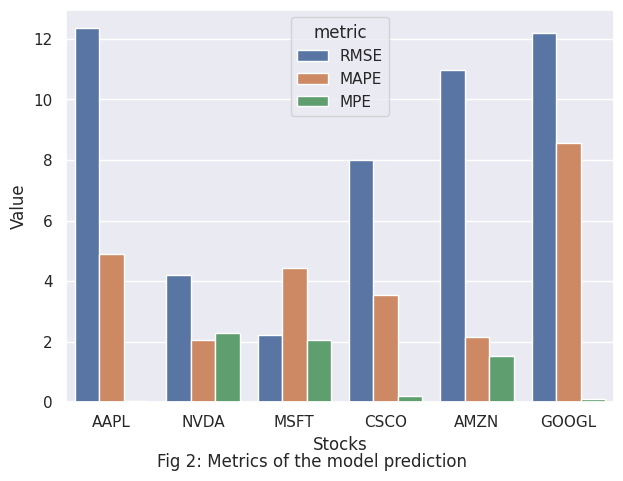

In [69]:
# metrics_df = calculateMetrics(result)
# melted_df = meltMetrics(metrics_df)
# melted_df
# plotMetrics(metrics_df)

# Performance Analysis

In [127]:
def gpuInfo():
    if torch.cuda.is_available():
        gpu = torch.cuda.get_device_properties(0)
        print(f'GPU: {gpu.name}\nMemory: {int(gpu.total_memory/1024/1024)}GB\nNumber of multiprocessors: {gpu.multi_processor_count}\n\
Threads per multiprocessor: {gpu.max_threads_per_multi_processor}')
    else: print("No GPU found, using CPUB.")

In [128]:
# gpuInfo()

GPU: NVIDIA GeForce RTX 4090
Memory: 24210GB
Number of multiprocessors: 128
Threads per multiprocessor: 1536


In [118]:
def trainingStats(result, daysToPredict):
    num_stocks = len(symbols)
    num_dates = int(len(result) / num_stocks)
    inferences = int(num_dates / daysToPredict + 1)
    print(f'Number of stocks: {num_stocks}')
    print(f'Number of dates: {num_dates}')
    print(f'Number of inferences: {inferences}')
    

In [ ]:
# trainingStats(result, 5)

In [122]:
def plotInferenceTime(result):
    plt.figure(figsize=(20,10))
    sns.set(style='ticks')
    sns.lineplot(data=result,x='DATETIME',y='TRAIN_DURATION',linewidth=2, color='blue')
    plt.figtext(0.5, 0.01, f'Fig 8: Inference time per point', ha='center')
    plt.ylabel('Seconds')
    plt.xlabel('Inference Point')

In [ ]:
# plotInferenceTime()